In [1]:
pacman::p_load(dplyr,ggplot2,tidyverse,patchwork,data.table,lme4,quantreg,bbmle,ggridges)

### Read in data from analysis notebook
`../process-all-fcs-data.ipynb`

In [2]:
final_data = data.frame(fread("../data/new_consol_2.csv"))

In [3]:
write.csv(final_data %>% dplyr::select(Strain,Rep,Position,Temperature,Date,ConcCellmL) %>%
     dplyr::distinct(), "../data/01-concentration-table.csv")

In [4]:
ssc_separated=final_data%>%
    dplyr::select(Strain,Position,Temperature,SSC_vals,FSC_vals,RedB_vals,GR_Calc_placeholder) %>%
    tidyr::separate_rows(SSC_vals,RedB_vals,FSC_vals,sep=",")

In [5]:
scatter_plot = ggplot(ssc_separated%>%dplyr::filter(!is.na(RedB_vals)) %>% 
     dplyr::mutate(RedB_vals=as.numeric(as.character(RedB_vals)),
                   SSC_vals=as.numeric(as.character(SSC_vals)),
                   FSC_vals=as.numeric(as.character(FSC_vals))) %>%
     dplyr::filter(!is.na(RedB_vals)&(RedB_vals!=0)&(SSC_vals!=0)&(!is.na(SSC_vals))&
       (FSC_vals!=0)&(!is.na(FSC_vals))&(GR_Calc_placeholder=="TF")) %>%
     dplyr::filter((log10(RedB_vals) > 5)&(log10(FSC_vals) > 5.5)) %>%dplyr::arrange(desc(RedB_vals)) %>%
     tidyr::pivot_longer(cols=-starts_with(c("Strain","Temperature","Position","GR_Calc_placeholder")),
                         values_to="Scatter",names_to="Type") %>%
     dplyr::mutate(Type=case_when(Type=="RedB_vals" ~ "~Mean chlorophyll",
                                  Type=="FSC_vals" ~ "~Mean cell size",
                                  Type=="SSC_vals" ~ "~Mean cell complexity")))+
    geom_density_ridges(aes(x=Scatter,fill=as.numeric(Temperature),group=paste0(Temperature,Strain),
                            #fill=factor(Temperature,levels=sort(unique(as.numeric(Temperature)))),
                            y=factor(Strain)),alpha=0.5)+ 
                 scale_x_log10() +
    scale_fill_gradient(low="light blue",high="maroon",name="Temperature") + theme_bw(base_size=12) + 
    xlab("laser value") + ylab("Strain") + facet_wrap(~Type,scales="free_x") 

In [6]:
write.csv(ssc_separated,"../data/ssc_separated.csv")

Picking joint bandwidth of 0.0315

Picking joint bandwidth of 0.00865

Picking joint bandwidth of 0.0181



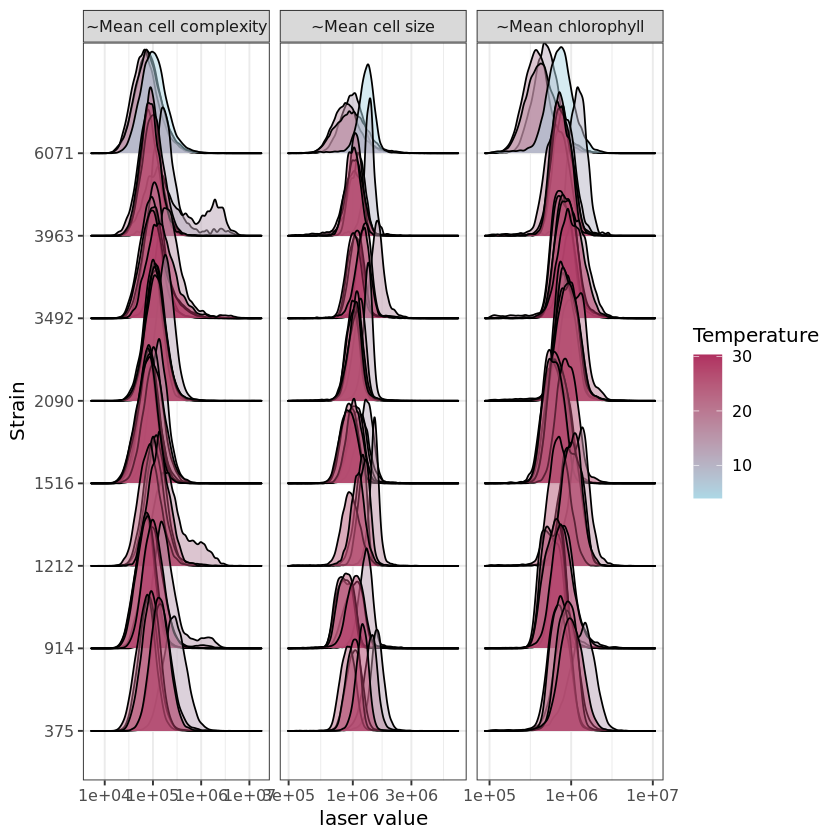

In [7]:
scatter_plot

In [8]:
ggsave(scatter_plot,file="../../figures/Suppl_scatter_vals.pdf")

Saving 6.67 x 6.67 in image


ERROR: Error in grDevices::pdf(file = filename, ..., version = version): cannot open file '../../figures/Suppl_scatter_vals.pdf'


### Workflow for parameter estimation

1. Fit curve with maximum likelihood
2. Perform optimization on resulting curve to find x-value of maximum to identify thermal optimum
3. Calculate x-intercepts of curves to identify thermal interval

In [ ]:
#### FUNCTIONS ####

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

LL1 <- function (y, x, a, b, w, o){
    N = nbcurve(x=x,a=a,b=b,w=w,opt=o)
    N[N<=0]=0.01
    N=N#log(N) # eliminate missing data from loglikelihood
    y=y#log(y)
    return(-sum(dnorm(y,N,log = TRUE))) # the negative log likelihoods: the order of N and y don't matter)
}

strain_color_frame_harriet = data.frame("Strains_full"=c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP374","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"),
                                        "Strains"=c("6856","6071","1212","3963",
                                                   "874","1280","4567","914","3492",
                                                   "371","1215","377","1239",
                                                   "1222","1256","374","379","1516",
                                                   "2090","375"),
                                        "Colors"=c("#4443c6","#c688ff","#7d328b","#da1b9d",
                                                  "#f87fa2","#b90033","#ff5755","#c31d0b",
                                                  "#ff6235","#ffc10c","#e4e366","#5a9f00",
                                                  "#60b574","#00b9bf","#0194e3","#C2C95E",
                                                  "#5EC9C9","#000000","#DBDBDB","#01452c"))

return_params <- function(fcm_frame,strain,return_gr_frame=FALSE) {
    if (strain=="6071_old") {
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter((Transfer=="C")|(Position==0)) %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    } else if (strain == 374) {
        temperature_correspond_jan20 = data.frame(Position = c(1:20),
                                    Temperature = c(7,8.5,9,11,12,14,15,17,18,19,20,21,21.5,23,23.5,25,
                                                   25.5,26,26.5,28))

        jan2020_data=read.csv("../../data/CombinedTimeSeries_Jan2020_Transfers.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        conc_accl=read.csv("../../data/Conc_Oct2020_374_379.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        growthrate_379_374=read.csv("../../data/GrowthRateStartEnd_374_379.csv") %>%
            dplyr::mutate(FirstLogDate=as.Date(FirstLogDate,format="%Y-%m-%d"),
                          FinalLogDate=as.Date(FinalLogDate,format="%Y-%m-%d"))
        first_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate",
                                                                              "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate",
                                                                                    "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FinalConc"="Conc"))

        first_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>% 
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate","Strain","Transfer","Position")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate","Transfer","Strain","Position")) %>%
            dplyr::rename(c("FinalConc"="Conc"))


        t1_grs = first_conc %>%
               dplyr::left_join(final_conc,by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain",
                                                "Position")) %>%
               dplyr::filter(Transfer==1)%>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_Transfer1=GrowthRate)%>%dplyr::select(Position,Temperature,GR_Transfer1)
        tf_grs = first_conc_post %>%
               dplyr::left_join(final_conc_post, by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain","Rep",
                                                "Position")) %>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_TransferF=GrowthRate) %>% dplyr::select(Position,Temperature,GR_TransferF)

        growth_rates=t1_grs %>% dplyr::left_join(tf_grs) %>% 
               dplyr::mutate(GrowthRate = dplyr::case_when((Temperature<10)|(Temperature>25) ~ GR_Transfer1,
                                                           TRUE ~ GR_TransferF)) %>%
            dplyr::filter(!is.na(GrowthRate)) %>% dplyr::mutate(Transfer="F") %>%
            dplyr::mutate(GrowthRate=case_when(Temperature==26.5 ~ 0.01,
                                               TRUE ~ GrowthRate))
    } else {
        print(strain)
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter(Transfer=="F") %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    }

    color_frame=strain_color_frame_harriet %>% dplyr::filter(Strains==as.character(strain))
    
    ## add extra known data points to drive parameterization
    ## for example, zero growth rates were not calculated, but we add them here since we assume all 
    ## negative growth rates to be zero.
    if (strain==1516) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(31.1,3),rep(9,3))),"Transfer"=c("F")))
        print(growth_rates %>% arrange(Temperature) %>% dplyr::select(Temperature,GrowthRate))
    }
    if (strain==2090) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,9),rep(0.01,9))),
                                        "Temperature"=as.numeric(c(rep(32,9),rep(9,9))),"Transfer"=c("F")))
    }
    
    if (strain==3492) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(34.4,3)),"Transfer"=c("F")))
    }
    
    if (strain==3963) {
        growth_rates = growth_rates %>% dplyr::filter(Temperature < 27) %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(0.01),
                                        "Temperature"=as.numeric(30.6),"Transfer"=c("F")))
    }
    
    
    if (strain==375) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=as.numeric(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(29,3),rep(9,3))),
                                        "Transfer"=c("F")))
    }
    if (strain==1212) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(12,3)),"Transfer"=c("F")))
    }
    
    
    if (strain==6071) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,9)),
                                        "Temperature"=as.numeric(rep(21,3),
                                                                 rep(2,9)),"Transfer"=c("F")))
    }
    
    
    if (strain==374) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,9),rep(0.00001,9)),
                                        "Temperature"=as.numeric(c(rep(7,9),rep(6,9))),"Transfer"=c("F")))
    }
    
    
    if (strain==371) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3)),"Transfer"=c("F")))
    }
    
    if (strain==914) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3),rep(9,3)),"Transfer"=c("F")))
    }

    
    if (strain==379) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(8,9)),"Transfer"=c("F")))
    }
    growth_rates = growth_rates %>% dplyr::mutate(Temperature=as.numeric(Temperature))
    
    if (return_gr_frame) {
        return(growth_rates)
    }
    
    ## Create reasonable guesses for thermal optimum & thermal width
    guess_opt = as.numeric(unique((growth_rates %>% 
                            dplyr::filter(GrowthRate==max(GrowthRate,na.rm=T)))$Temperature))
    
    guess_wid = as.numeric(unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==max(Temperature,na.rm=T)))$Temperature) - 
                           unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==min(Temperature,na.rm=T)))$Temperature))

    
    x = sort(runif(100,-5,40))
    a = 0.1 # scale param 1
    b = 0.01 # scale param 2
    o_guess = guess_opt # optimum temperature
    w_guess=15
    if ((guess_wid!=0)&(!is.na(guess_wid))) {
        w_guess = guess_wid # thermal niche width
    }
    
    #We want the indepdendet variable to have global scope--
    # i.e. to be available to all functions.
    
    ## Bootstrap additional data points to be used to fit the model
    bootstrapped_points = data.frame()
    for (temp in unique(growth_rates$Temperature)) {
        gr <- mean(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        sd_gr <- sd(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        chisq <- rchisq(1,df=(nrow(growth_rates)-1))
        n <- rnorm(10000, mean = gr, sd = sd_gr*sqrt((nrow(growth_rates)-1)/chisq))
        bootstrapped_points = bootstrapped_points %>%
            dplyr::bind_rows(data.frame("Temperature"=rep(temp,10000),
                                        "GrowthRate"=n)) %>% dplyr::filter(!is.na(GrowthRate)&
                                                                           (GrowthRate>=0))
    }
    
    bootstrapped_points=growth_rates %>% dplyr::arrange(Temperature)
    
    bestguess=10000
    best_m=NA
    print(paste0(bestguess,"Best guess"))
    m1=best_m
    
    m1 = bbmle::mle2(minuslogl = LL1, start = list(a = a, b = b,
                                            o = o_guess,w = w_guess),
              data = list(y=as.numeric(bootstrapped_points$GrowthRate),
                          x=as.numeric(bootstrapped_points$Temperature)),
              control=list(maxit=1000000,abstol=1e-20))
    if (strain==375){
        print(m1)
    }
    print(summary(m1)@coef["b","Estimate"])
    print("^b")

    y = nbcurve(x=x,
            a=summary(m1)@coef["a","Estimate"],
            b=summary(m1)@coef["b","Estimate"],
            w=summary(m1)@coef["w","Estimate"],
            opt=summary(m1)@coef["o","Estimate"])
    plot_frame=data.frame(x=x,
                          y=y,
                          type="Modeled") %>% 
            dplyr::bind_rows(data.frame(x=bootstrapped_points$Temperature,
                             y=bootstrapped_points$GrowthRate,
                             type="Measured")) %>%
            dplyr::mutate(x=as.numeric(x)) %>%
            dplyr::arrange(x)
    plot(x,y, typ='l', col=color_frame$Colors[1], cex.lab = 1.5, cex = 1.5,
    xlab="Temperature", ylab="Growth Rate",
    ylim=c(0,1.5))
    points(growth_rates$Temperature,growth_rates$GrowthRate,col=color_frame$Colors[1],pch=18)
    points(bootstrapped_points$Temperature,bootstrapped_points$GrowthRate,col="black",pch=18)
    title(as.character(strain))
    coef_list = data.frame("a"=summary(m1)@coef["a","Estimate"],
            "b"=summary(m1)@coef["b","Estimate"],
            "w"=summary(m1)@coef["w","Estimate"],
            "opt"=summary(m1)@coef["o","Estimate"],"a_err"=summary(m1)@coef["a","Std. Error"],
            "b_err"=b,
            "w_err"=summary(m1)@coef["w","Std. Error"],
            "opt_err"=summary(m1)@coef["o","Std. Error"],"Strain"=strain)
    return(list(data.frame("Temperature"=x,
                      "ModeledPoints"=y,"Type"="Model",
                      "Strain"=strain) %>% 
           dplyr::bind_rows(data.frame("MeasuredPoints"=growth_rates$GrowthRate,
                                       "Temperature"=as.numeric(growth_rates$Temperature),"Type"="Measure",
                                       "Strain"=strain)),coef_list))
}

par(mfrow = c(3, 2))
all_params=data.frame()
all_params_coef=data.frame()
for (strain in c(374,3963,3492,1516,874,375,2090,379,1212,371,6071,914)) {
    paramslist=return_params(final_data,strain=strain)
    all_params=all_params%>%dplyr::bind_rows(paramslist[[1]])
    all_params_coef=all_params_coef%>%dplyr::bind_rows(paramslist[[2]])
}

In [ ]:
ggplot(all_params %>%dplyr::mutate(Strain=as.character(Strain))) + 
    geom_line(data=all_params%>% dplyr::filter(!is.na(ModeledPoints)) %>%
                                 dplyr::mutate(Strain=factor(as.character(Strain))),
    aes(x = Temperature,y=ModeledPoints,group=Strain,color=factor(Strain)))+ 
    geom_point(data=all_params%>% dplyr::filter(is.na(ModeledPoints)) %>%
                                 dplyr::mutate(Strain=factor(as.character(Strain))),
    aes(x = Temperature,y=MeasuredPoints,group=Strain,color=factor(Strain))) + 
    ylim(c(0,1.5)) + scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Colors) + 
    facet_wrap(~Strain,ncol=3)

In [ ]:
ggplot(all_params %>%dplyr::filter(Strain%in%c(914,874,371,1212,3963)) %>%
                                   dplyr::mutate(Strain=as.character(Strain))) + 
    geom_line(data=all_params%>%dplyr::filter(Strain%in%c(914,874,371,1212,3963))%>% 
              dplyr::filter(!is.na(ModeledPoints)) %>%
                                 dplyr::mutate(Strain=factor(as.character(Strain))),
    aes(x = Temperature,y=ModeledPoints,group=Strain,color=factor(Strain)),lwd=2)+ 
    geom_point(data=all_params%>%dplyr::filter(Strain%in%c(914,874,371,1212))%>% 
               dplyr::filter(is.na(ModeledPoints)) %>%
                                 dplyr::mutate(Strain=factor(as.character(Strain))),
    aes(x = Temperature,y=MeasuredPoints,group=Strain,color=factor(Strain))) + 
    ylim(c(0,1.5)) + scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors)+
    theme_test(base_size=12)
ggsave("selected_strains.pdf")

In [ ]:
print_summaries <- function(dataframe_in,column) {
    curr_data=dataframe_in[column]
    print(paste("Min of column",column,"is",round(min(curr_data),2),sep=" "))
    print(paste("Max of column",column,"is",round(max(curr_data),2),sep=" "))
    print(paste("Range of column",column,"is",round(max(curr_data)-min(curr_data),2),sep=" "))
}
print_summaries(all_params_coef,"opt")
print_summaries(all_params_coef,"w")

In [ ]:
cor.test(c(1:10),c(20:29)*3, method="kendall")


In [ ]:
ggplot(all_params_coef) + geom_point(aes(x=opt,y=w,color=factor(Strain)),size=4)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=16) + xlab("Thermal optimum (°C)") + ylab("Thermal width (°C)")
ggsave("width_v_opt.pdf")

In [ ]:
ALL_EHUX = read.csv('/vortexfs1/omics/alexander/halexander/2020-Ehux/RCC-parsing/EHUX_all_strains.csv')

ALL_EHUX %>% dplyr::select(X,RCC.temperature,Latitude,Longitude)%>%
    dplyr::filter(X %in% c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP74","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"))%>%
    dplyr::bind_rows(data.frame("X"=c("CCMP371","CCMP1280","CCMP375","CCMP377","CCMP1516/2090","CCMP379"),
                                "Latitude"=c(32,-12,32,43,-2.67,50.17),
                                "Longitude"=c(-62,-35,-62,-68,-82.72,-4.25), # deposit date is used if sampling unavailable
                                "SamplingYear"=c(1987,1990,1967,1988,1992,NA),
                                "SamplingMonth"=c(6,10,2,9,9,NA)))

other_isolation_dates = data.frame("X"=c("RCC874","RCC914","RCC1212","RCC1215","RCC1222",
                                         "RCC1239","RCC1256","RCC3492","RCC3963","RCC6071"),
                                   "SamplingYear"=c(2004,2004,2000,2001,1998,2002,1999,2011,
                                                    2011,2018),
                                   "SamplingMonth"=c(11,10,9,2,7,4,7,12,10,3),
                                   "SamplingDepth"=c(5,10,3,NA,20,NA,NA,0,NA,10),
                                   "SamplingTemp"=c(NA,27.78,NA,NA,NA,NA,NA,NA,NA,NA))

sample_t_frame = ALL_EHUX %>% dplyr::select(X,RCC.temperature,Latitude,Longitude)%>%
    dplyr::filter(X %in% c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP74","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"))%>%
    dplyr::left_join(other_isolation_dates,by=c("X"))%>%
    dplyr::bind_rows(data.frame("X"=c("CCMP371","CCMP1280","CCMP375","CCMP377","CCMP1516","CCMP2090","CCMP379"),
                                "Latitude"=c(32,-12,32,43,-2.67,-2.67,50.17),
                                "Longitude"=c(-62,-35,-62,-68,-82.72,-82.72,-4.25), # deposit date is used if sampling unavailable
                                "SamplingYear"=c(1987,1990,1967,1988,1992,1992,NA),
                                "SamplingMonth"=c(6,10,2,9,9,9,NA),
                                "SamplingTemp"=c(NA,NA,NA,NA,NA,NA,NA)))

sample_t_frame

In [ ]:
final_merge_df=sample_t_frame %>% separate(X,into=c("RCC","StrainRCC"),sep="RCC") %>%
    tidyr::separate(RCC,into=c("CCMP","StrainCCMP"),sep="CCMP") %>%
    dplyr::mutate(Strain=as.numeric(case_when(is.na(StrainCCMP)~StrainRCC,
                                   StrainCCMP=="1516/2090"~"1516",
                                   TRUE ~ StrainCCMP)))

In [ ]:
ggplot(all_params_coef %>% dplyr::left_join(final_merge_df)) + geom_point(aes(x=opt,y=w,color=factor(Strain)),size=4)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=16) + xlab("Thermal optimum (°C)") + ylab("Thermal width (°C)")
ggsave("width_v_opt.pdf")

In [ ]:
ggplot(all_params_coef %>% dplyr::left_join(final_merge_df)) + geom_point(aes(y=opt,x=Latitude,color=factor(Strain)),size=4)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=16) + ylab("Thermal optimum (°C)") + xlab("Latitude")+
   geom_smooth(data=all_params_coef %>% dplyr::left_join(final_merge_df),
               method="lm", aes(x=Latitude,y=opt,color="Exp Model"), formula= (y ~  x + I(x^2)), se=FALSE, linetype = 1)
ggsave("opt_v_latitude.pdf")

In [ ]:
ggplot(all_params_coef %>% dplyr::left_join(final_merge_df)) + geom_point(aes(y=w,x=Latitude,color=factor(Strain)),size=4)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=16) + ylab("Thermal optimum (°C)") + xlab("Latitude")+
   geom_smooth(data=all_params_coef %>% dplyr::left_join(final_merge_df),
               method="lm", aes(x=Latitude,y=w,color="Exp Model"), formula= (y ~  x + I(x^2)), se=FALSE, linetype = 1)
ggsave("width_v_latitude.pdf")

In [ ]:
summary(lm(formula= (opt ~  Latitude + I(Latitude^2)),data=all_params_coef %>% 
           dplyr::left_join(final_merge_df)))

In [ ]:
summary(lm(formula= (opt ~  Latitude + I(Latitude^2)),data=all_params_coef %>% 
           dplyr::left_join(final_merge_df)))

In [ ]:
cor.test(all_params_coef$opt,all_params_coef$w, method="kendall")



In [ ]:
best_gr_frame=data.frame()
for (curr in 1:nrow(all_params_coef)) {
    best_gr_frame=best_gr_frame %>% dplyr::bind_rows(data.frame(Strain=all_params_coef$Strain[curr],
                                                            Temperature = all_params_coef$opt[curr],
                                                            ModeledPoints = nbcurve(all_params_coef$opt[curr],
                                                                                    opt=all_params_coef$opt[curr],
                                                                         a=all_params_coef$a[curr],
                                                                         w=all_params_coef$w[curr],
                                                                         b=all_params_coef$b[curr]),
                                                            w = all_params_coef$w[curr],
                                                            opt = all_params_coef$opt[curr]))
}

In [ ]:
cor.test(best_gr_frame$ModeledPoints,best_gr_frame$w, method="kendall")

In [ ]:
print_summaries(best_gr_frame,"ModeledPoints")

In [ ]:
built_gr_df = data.frame()
for (curr in 1:nrow(all_params_coef)) {
    built_gr_df=built_gr_df %>% dplyr::bind_rows(data.frame(Strain=all_params_coef$Strain[curr],
                                                            Temperature = seq(0,30,by=0.01),
                                                            ModeledPoints = nbcurve(seq(0,30,by=0.01),
                                                                                    opt=all_params_coef$opt[curr],
                                                                         a=all_params_coef$a[curr],
                                                                         w=all_params_coef$w[curr],
                                                                         b=all_params_coef$b[curr])))
}

growth_curves_fig = ggplot(built_gr_df %>% dplyr::filter(!is.na(ModeledPoints)))+geom_line(aes(x = Temperature,y=ModeledPoints,group=Strain,
                                  color=factor(Strain)),lwd=2)+ 
    ylim(c(-0.1,1.5)) + scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                                           name="Strain")+
    theme_test(base_size=12) + xlab("Temperature (°C)") + ylab("Modeled growth rate (1/day)")
growth_curves_fig
ggsave("growth_curve_fig.pdf")

In [ ]:
revised_df =data.frame()
for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    revised_df = revised_df %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_opt=opt_val))
}

In [ ]:
revised_df_width =data.frame()
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    if (recalculate) {
        wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
        wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
    }
    revised_df_width = revised_df_width %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_wid=abs(wid_eq_2-wid_eq_1)))
}

In [ ]:
revised_df_plateau =data.frame() ## range of temperatures within 10% of max GR. 
# we set res to be 10% of opt on either side.
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

for (strain_curr in all_params_coef$Strain) {
    a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a
    b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b
    w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w
    opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=a,
         b=b,
         w=w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
    temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                   to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
    window_1 = -100
    window_2 = -100
    print(paste0(tolerance_val,"; window",window_1," to ",window_2,"; strain:",strain_curr))
    for (temp in temps_test) {
        if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
            window_1 = temp
        }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
            window_2=temp
        }
    }
    revised_df_plateau = revised_df_plateau %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_plateau=abs(window_1-window_2),
                                    low_temp=window_1,high_temp=window_2,topt=opt_val,
                                    best_gr = nbcurve(opt_val,opt,w,a,b), opt_param=opt,
                                    a_param=a,b_param=b,w_param=w))
}

In [ ]:
revised_df_plateau$left_plateau=revised_df_plateau$topt-revised_df_plateau$low_temp
revised_df_plateau$right_plateau=revised_df_plateau$high_temp-revised_df_plateau$topt

In [ ]:
revised_df_plateau

In [ ]:
print_summaries(revised_df_plateau,"Revised_plateau")

In [ ]:
cor.test(revised_df_plateau$Revised_plateau,revised_df_plateau$opt, method="kendall")

In [ ]:
cor.test(revised_df_plateau$Revised_plateau,revised_df_plateau$best_gr, method="kendall")

In [ ]:
cor.test(revised_df_plateau$Revised_plateau,revised_df_plateau$w_param, method="kendall")

In [ ]:
cor.test(revised_df_plateau$Revised_plateau,revised_df_plateau$w_param, method = 'spearman')

In [ ]:
ggplot(revised_df_width) + geom_point(aes(x=Strain,y=Revised_wid,
                                            fill=factor(Strain)),pch=21,size=4) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotdash")+ theme_bw(base_size=12)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 

In [ ]:
ggplot(revised_df_plateau) + geom_point(aes(x=Strain,y=Revised_plateau,
                                            fill=factor(Strain)),pch=21,size=4) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotdash")+ theme_bw(base_size=12)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 

In [ ]:
ggplot(revised_df_plateau) + geom_point(aes(x=left_plateau,y=right_plateau,fill=factor(Strain)),pch=21,size=4) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotdash")+ theme_bw(base_size=12)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 

In [ ]:
plateau_plot = ggplot(revised_df_plateau)+ #%>% tidyr::pivot_longer(id_cols=c("Strain","Revised_plateau"),
                          #                        names_to="type",values_to="temp")) + 
    geom_segment(aes(x=low_temp,xend=high_temp,y=factor(Strain,levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),
                     yend=factor(Strain,levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),color=factor(Strain)),lwd=2) + 
    geom_point(aes(x=low_temp,y=factor(Strain,levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),color=factor(Strain)),size=5) + 
    geom_point(aes(x=high_temp,y=factor(Strain,levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),color=factor(Strain),color=factor(Strain)),size=5) + 
    xlab("Modeled temperatures (°C) within 90%\nof growth rate at optimum temp")+ 
    ylab("Strain") + theme_bw(base_size=12)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
plateau_plot

ggsave("plateau_plot.pdf")

In [ ]:
ggplot(all_params_coef%>%dplyr::left_join(revised_df) %>% dplyr::arrange(desc(Revised_opt)) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_bar(aes(x = Strain, y =Revised_opt,fill=Strain), stat="identity") +theme_bw(base_size=12) + 
    theme(legend.position="none") + xlab("") + ylab("Optimum temperature (°C)") + 
    scale_fill_manual(breaks=as.character(strain_color_frame_harriet$Strains),
                                        limits=as.character(strain_color_frame_harriet$Strains),
                                        values=strain_color_frame_harriet$Colors) 

In [ ]:
width_matrix = ggplot(all_params_coef%>%dplyr::left_join(revised_df) %>% dplyr::left_join(revised_df_width) %>% 
       dplyr::arrange(desc(Revised_opt)) %>%
       dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_segment(aes(x = 12, xend =Revised_opt,y=Revised_wid,
                     yend=Revised_wid,color=Strain),pch=21,size=1)+theme_bw(base_size=12) +
    geom_segment(aes(y = 15, yend =Revised_wid,x=Revised_opt,
                     xend=Revised_opt,color=Strain),pch=21,size=1)+theme_bw(base_size=12) +
    geom_point(aes(x = Revised_opt, y =Revised_wid,fill=Strain),pch=21,size=7)+theme_bw(base_size=12) + 
    ylab("Thermal width (°C)") + xlab("Optimum temperature (°C)") + 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
width_matrix

In [ ]:
ggplot(all_params_coef%>%dplyr::left_join(revised_df) %>%
          #dplyr::left_join(revised_df_width) %>% dplyr::arrange(desc(Revised_wid)) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))) %>%
    dplyr::select(colnames(.)[!grepl("err",colnames(.))]) %>%
    tidyr::pivot_longer(cols=!starts_with("Strain"),names_to="Param",values_to="Value") %>%
    dplyr::mutate(WidthOpt=case_when((Param%in%c("a","b"))~"Shape",
                                     TRUE ~ "Shift"))) + 
    geom_point(aes(x=Param,y=Value,fill=Strain),pch=21,size=4)+ 
    geom_text(aes(x=Param,y=Value,label=Strain),pch=21,size=4)+ 
    scale_fill_manual(breaks=as.character(strain_color_frame_harriet$Strains),
                                        limits=as.character(strain_color_frame_harriet$Strains),
                                        values=strain_color_frame_harriet$Colors) + 
    facet_wrap(~WidthOpt,scale="free",nrow=2) + theme_bw(base_size=14) + ylab("Parameter value (no dimension or °C)")

In [ ]:
ggplot(all_params_coef%>%dplyr::left_join(revised_df) %>%
          dplyr::left_join(all_params %>% dplyr::group_by(Strain) %>% 
                           dplyr::filter(MeasuredPoints==max(MeasuredPoints,na.rm=T))) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_point(aes(x = w, y =MeasuredPoints,fill=Strain), size=4,pch=21) +
    theme_bw(base_size=12) + 
    #theme(legend.position="none") + 
    ylab("Estimated maximum growth rate (1/day)") + xlab("Estimated thermal width (°C)") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    ggtitle("Thermal width")